## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

**Описание эксперимента**
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

**Описание колонок**
- value – значения метрики
- experimentVariant – Вариант теста (Control – контроль, Treatment – тест) 

**Задача**
Сравните результат между тестом и контролем по двум кейсам:
- Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
- Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value

[Данные](https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv "Данные")

Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [22]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pylab as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')
%matplotlib inline


In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [3]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

# 1. Загрузим и посмотрим на данные

In [11]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';', index_col=0)
data

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control
...,...,...
996,1000,Treatment
997,1200,Treatment
998,1500,Treatment
999,2000,Treatment


In [12]:
data.isna().value_counts()

value  experimentVariant
False  False                1000
dtype: int64

In [14]:
data.dtypes

value                object
experimentVariant    object
dtype: object

In [18]:
data['value'] = data['value'].apply(lambda x: x.replace(',', '.')).astype('float')

In [19]:
data.dtypes

value                float64
experimentVariant     object
dtype: object

In [20]:
data.groupby('experimentVariant').describe()

value             ...                        
                   count       mean  ...        75%          max
experimentVariant                    ...                        
Control            500.0  10.026867  ...  10.664879    13.130346
Treatment          500.0  27.321499  ...  10.675721  3000.000000

[2 rows x 8 columns]

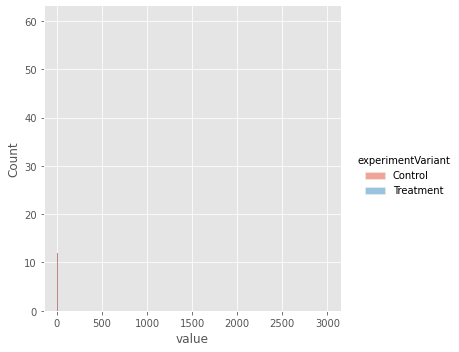

In [24]:
sns.displot(data=data, x='value', hue='experimentVariant')

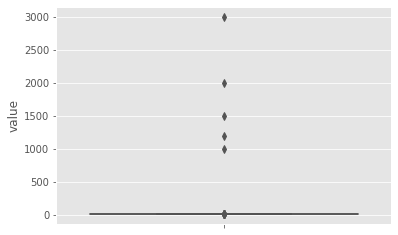

In [29]:
sns.boxplot(data=data, y='value', hue='experimentVariant')

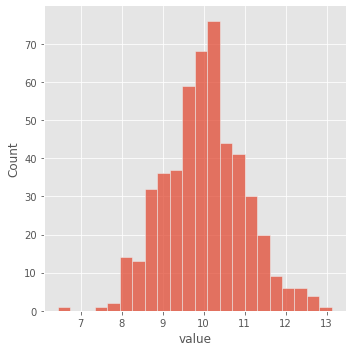

In [30]:
sns.displot(data=data[data.experimentVariant == 'Control'], x='value')

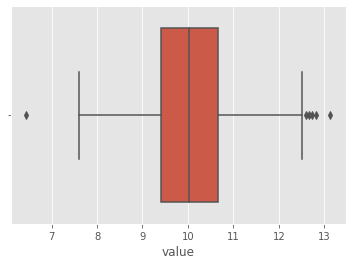

In [38]:
sns.boxplot(data=data.query("experimentVariant == 'Treatment' & value < 1000"), x='value')

In [40]:
data.query("value < 1000").groupby('experimentVariant').describe()

value                       ...                                 
                   count       mean       std  ...        50%        75%        max
experimentVariant                              ...                                 
Control            500.0  10.026867  0.979377  ...  10.018465  10.664879  13.130346
Treatment          495.0  10.021716  0.978140  ...  10.015492  10.652341  13.130346

[2 rows x 8 columns]

Тестовые данные имеют некоторое колиечество выбросов, которые сильно искажают визуализацию и оказывают влияние на стандартное отклонение, среднее, однако на основные квантили влияние минимально.
Для чистоты эксперимента оставим эти данные, т.к. для их исключения необходимо разобраться в сути выбросов: это могут быть ошибки записи, ошибки алгоритма и т.д. Точно сказать не можем, поэтому оставляем

# 2. Применение bootstrap по среднему и медиане

In [44]:
data_test = data.query("experimentVariant == 'Treatment'").value
data_control = data.query("experimentVariant == 'Control'").value

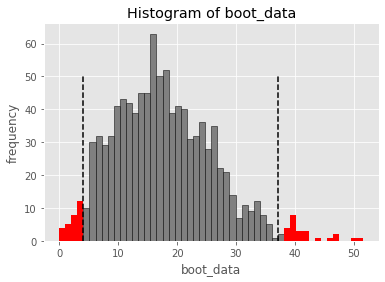

In [45]:
boot_mean = get_bootstrap(data_test, data_control, boot_it=1000, statistic=np.mean)

In [55]:
print(f"p-value при исследовании средних двух выборок методом bootstrap равняется: {boot_mean['p_value']}")

p-value при исследовании средних двух выборок методом bootstrap равняется: 0.03631190215765206


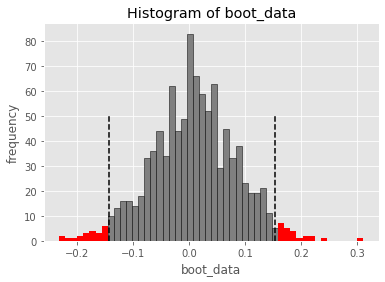

In [65]:
boot_median = get_bootstrap(data_test, data_control, boot_it=1000, statistic=np.median)

In [67]:
print(f"p-value при исследовании медиан двух выборок методом bootstrap равняется: {boot_median['p_value']}")

p-value при исследовании медиан двух выборок методом bootstrap равняется: 0.9097857878653776


# 3. Сравним выборки непараметрическим тестом Манна-Уитни

In [56]:
from scipy.stats import mannwhitneyu

In [57]:
mannwhitneyu(data_control, data_test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

# 4. Сравним выборки с учетом исключения выбросов

In [58]:
data_test_2 = data.query("experimentVariant == 'Treatment' & value < 1000").value
data_control_2 = data.query("experimentVariant == 'Control' & value < 1000").value

mannwhitneyu(data_control_2, data_test_2)

MannwhitneyuResult(statistic=123310.5, pvalue=0.4614193132073732)

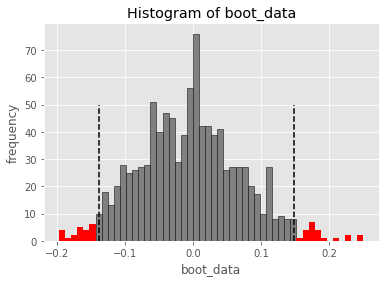

In [64]:
boot_medeian_2 = get_bootstrap(data_test_2, data_control_2, boot_it=1000, statistic=np.median)

In [61]:
boot_medeian_2['p_value']

0.9518146226762405

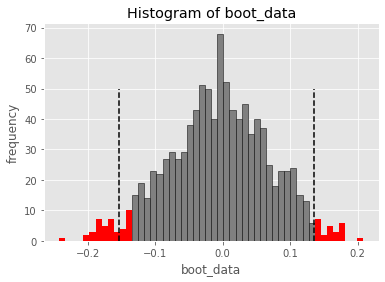

In [63]:
boot_mean_2 = get_bootstrap(data_test_2, data_control_2, boot_it=1000, statistic=np.mean)

In [62]:
boot_mean_2['p_value']

0.9234639637896302

# 4. Вывод



1.   С учётом выбросов    
    *   Непараметрический тест показал, что мы не можем отбросить нулевую гипотезу о схожести между выборками
    * Сравнение **медиан** методом bootstrap также показало, что мы не можем отбросить нулевую гипотезу: распределение разницы средних с учётом доверительного интервала включало в себя нулевое значение
    * *Сравнение **средних** методом bootstrap дало p-value = 0.036, что меньше 0.05. На основании этого теста можем сделать вывод, что средние в двух выборках отличаются*  
2.   Без учёта выбросов    
    * Все методы показали, что между выборками отсутствуют статистически значимые различия.

Итого, если брать в расчёт крайне высокие значения(>1000) в тестовой группе, то по Манна-Уитни средние не будут различаться, а по bootstrap-методу различия  будут. Статистический значимых различий в медианах двух выборках на основании bootstrap-метода не будет.    
Метод Манна-Уитни показал себя устойчивым к выбросам.    
Для дальнейших исседований необходимо понять природу выбросов: если они имеют место быть, то получается неоднозначный результат, когда один тест(u-test) говорит, что различий нет, а другой(bootstrap) - есть. Тогда можно опираться на сравнение медиан в выборках, как более устойчивую метрику.    
Если выбросы - это всё-таки ошибка при проведении эксперимента, записи данных и т.д., то можем принять, что статистически значимых различий между тестовой и контрольной групп нет. 
